In [108]:
# Enable interactive plot
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

# only do longitudual friction
# print("x = {0}".format(x))

def skew(vector):
    "Given a vector, return its skew symmetric matrix"
    return np.array(([0, -vector[2], vector[1]],
                     [vector[2], 0, -vector[0]],
                     [-vector[1], vector[0], 0]))
def inv_skew(matrix):
    "Given a matrix, return its inverse skew symmetric vector"
    return np.array((matrix[2][1],-matrix[2][0],matrix[1][0]))

def angle_axis(R):
    "Given a rotation matrix, return its axis and angle"
    theta = np.arccos((np.trace(R)-1)/2)
    u = np.multiply((1/(2*np.sin(theta))),inv_skew(R-np.transpose(R)))
    return theta, u

def matrix_log(R):
    "Given a rotation matrix, return its matrix log"
    theta, u = angle_axis(R)
    return theta*u

def matrix_exp(theta, u):
    "Given theta and the axis, return its matrix exp"
    matmul = np.matmul(skew(u),skew(u))
    return np.eye(3) + np.sin(theta)*skew(u) + (1 - np.cos(theta))*matmul

def grad_h(func, nodes, axis): # Gradiant h
    """ Modified trapezoidal integration"""
    # Pads a 0 at the end of an array
    temp = pad_along_axis(func, nodes,axis = 1) # Using roll calculate the diff (ghost node of 0)
    return (temp - np.roll(temp, 1))

def A_h(func, nodes, axis):
    temp = pad_along_axis(func,nodes,axis)
    for i in range(nodes):
        if i == 0:
            temp[:,i] = func[:,i] / 2
        
        elif i > 0 and i < nodes-1:
            temp[:,i] = (func[:,i] + func[:,i-1]) / 2
        
        elif i == nodes-1:
            temp[:,i] = func[:,i-1]/2 
            
    return(temp)


def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)


class crossrod:
    def __init__(self, T, dt, total_length, elements, density, radius, total_external_force,
                 G = 1E4, E = 1E5, dim = 3, **kwargs):
        # Plotting for Milestone 1
        # self.final_pos = []

        
        # Plotting for Milestone 2
        self.time_elapsed = 0
        
        # Plotting for Milestone 2
        self.record_mid_pos = []
        self.record_1st_pos = []
        self.record_3rd_pos = []
        self.record_mid_vel = []

        # Element Info
        self.e = elements
        self.n = self.e + 1 # nodes
        self.n_i = self.e - 1 # internal nodes

        # Initializing node mass
        self.area = np.pi * (radius**2) # Update?
        total_volume = self.area * total_length
        total_mass = density * total_volume
        self.m = np.zeros((1,self.n))
        element_mass = total_mass / self.e
        self.m[0][0] = element_mass/2
        self.m[0][1:self.n-1] = element_mass
        self.m[0][self.n-1] = element_mass/2
        

        # Initializing node radii
        self.r = np.full((1,self.n),radius)

        # Initializing node position
        self.pos = np.zeros((dim,self.n))
        # Milestone 1 position
        for col in range(self.n):
            self.pos[2,col] = (total_length/self.e) * col
            
        print(self.pos)

        # Length Info
        # UPDATE THIS AT EVERY TIME STEP
        self.l = self.pos[:,1:] - self.pos[:,:-1] # length vector
        self.l_mag = np.linalg.norm(self.l, axis = 0) # magnitude of length
        # DO NOT UPDATE THIS AT EVERY TIME STEP
        self.l_ref = self.pos[:,1:] - self.pos[:,:-1] # reference length (unstrecthed length of the rod)
        self.l_ref_mag = np.linalg.norm(self.l_ref, axis = 0) # magnitude of reference length as a scalar

               
        # Domain
        # UPDATE THIS AT EVERY TIME STEP
        self.domain = np.zeros((self.e))
        for idx in range(self.e):
            if idx < self.e - 1:
                self.domain = (self.l_mag[idx+1] + self.l_mag[idx])/2
            
            elif idx == self.e - 1:
                self.domain = self.l_mag[idx]
                
        #Ref Domain
        # DO NOT UPDATE THIS AT EVERY TIME STEP
        self.domain_hat = np.zeros((self.e))
        for idx in range(self.e):
            if idx < self.e - 1:
                self.domain_hat = (self.l_ref_mag[idx+1] + self.l_ref_mag[idx])/2
            
            elif idx == self.e - 1:
                self.domain = self.l_ref_mag[idx] 
                
        #Epsillon
        # UPDATE THIS AT EVERY TIME STEP
        self.epsilon =  self.domain / self.domain_hat 
        
        # Parameters determined by Length Info
        self.dil_fac = np.full((1,self.e),1) # dilatation factor
        self.tangents = self.l / self.l_mag # tangent vectors

        # Directors (maps from lab to material frame)
        self.directors = np.zeros((3, 3, self.e))
        # for milestone 2
        # self.directors[:,:,0] = np.array(([np.sin(45), np.cos(45), 0.0],
        #                                   [0.0, 0.0, 1.0],
        #                                   [np.cos(45), -np.sin(45), 0.0]))
        # self.directors[:,:,1] = np.array(([-np.sin(45), np.cos(45), 0.0],
        #                                   [0.0, 0.0, 1.0],
        #                                   [np.cos(45), np.sin(45), 0.0]))

#         self.directors[:,:,0] = np.array(([0.0, 0.0, 1.0],
#                                           [np.sin(45), np.cos(45), 0.0],
#                                           [np.cos(45), -np.sin(45), 0.0]))
#         self.directors[:,:,1] = np.array(([0.0, 0.0, 1.0],
#                                           [-np.sin(45), np.cos(45), 0.0],
#                                           [np.cos(45), np.sin(45), 0.0]))

        self.directors[:,:,0] = np.array(([0.0, 1.0, 0.0],
                                          [0.0, 0.0, 1.0],
                                          [1.0, 0.0, 0.0]))
        self.directors[:,:,1] = np.array(([0.0, 1.0, 0.0],
                                          [0.0, 0.0, 1.0],
                                          [1.0, 0.0, 0.0]))
        # for generalized case
        # for idx in range(self.e):
        #     self.directors[:, :, idx] = np.eye(3)

        # No forces in milestone 2
        self.forces = np.zeros((dim,self.n)) # forces INITIALIZE

        # Milestone 1 force
        # self.forces[2,self.e] = total_external_force

        self.vel = np.zeros((dim,self.n)) # velocities
        self.ang_vel = np.zeros((dim,self.e)) # angular velocities

        # Shear/stretch diagonal matrix INITIALIZE INPUT FROM MATERIAL PROPERTIES
        self.S_hat = np.zeros((3,3,self.e))
        alpha_c = 4./3. # shape factor
        self.S_hat[0,0,:] = alpha_c * G * self.area
        self.S_hat[1,1,:] = alpha_c * G * self.area
        self.S_hat[2,2,:] = E * self.area

        # Moment of inertia diagonal matrix
        self.I = np.zeros((3,3,self.e))
        self.I[0,0,:] = self.area**2 / 4 * np.pi
        self.I[1,1,:] = self.area**2 / 4 * np.pi
        self.I[2,2,:] = self.area**2 / 4 * np.pi * 2

        # Bend diagonal matrix INITIALIZE INPUT FROM MATERIAL PROPERTIES
        self.B = np.zeros((3,3,self.n_i))
        self.B[0,0,:] = E * self.I[0,0,1:]
        self.B[1,1,:] = E * self.I[1,1,1:]
        self.B[2,2,:] = G * self.I[2,2,1:]

        # J diagonal matrix.
        # **** if broken code, there might be some difference between dJ^ and J^
        # here i assume J is pI from dJ = pIds
        self.dJ = np.zeros((3,3,self.e))
        self.dJ[0,0,:] = (density * self.I[0,0,:])/self.e
        self.dJ[1,1,:] = (density * self.I[1,1,:])/self.e
        self.dJ[2,2,:] = (density * self.I[2,2,:])/self.e

        # kappa here
        self.kappa = np.zeros((3,self.n_i))
        for idx in range(self.n_i):
            self.kappa[:,idx] = -(matrix_log(np.matmul(self.directors[:,:,(idx+1)],np.transpose(self.directors[:,:,idx]))))/self.l_mag[idx]

        # shear/stress strain
        self.sigma = np.einsum('ijk,jk->ik',self.directors,(self.dil_fac * self.tangents - self.directors[2,:,:]))
        # self.sigma = self.directors * (self.dil_fac * self.tangents - self.directors[2,:,:])

        # Governing Equations
        # pos += vel * dt # Equation 1
        # dv_dt = (grad_h(S_hat @ s / dil_fac) + f) / m # Equation 3

    def step(self, dt):
        self.directors, self.ang_vel = self.angular_verlet(dt, self.directors, self.ang_vel)
        self.pos, self.vel = self.position_verlet(dt, self.pos, self.vel)
        self.bend_update(self.directors)
        self.force_update(self.pos)
        self.time_elapsed += dt
        pass

    def position_verlet(self, dt, x, v):
        # x = position & v = velocity
        temp_x = x + 0.5*dt*v
        v_n = v + dt * self.force_rule(temp_x)
        x_n = temp_x + 0.5 * dt * v_n
        return x_n, v_n

    def angular_verlet(self, dt, Q, w):
        # Q = directors & w = angular velocity
        temp_Q = np.zeros((3,3,self.e))
        norm_w = np.linalg.norm(w,axis=0)+1E-14
        for idx in range(self.e):
            temp_Q[:,:,idx] = matrix_exp((-dt/2)*(180/np.pi)*norm_w[idx],(w[:,idx]/(norm_w[idx]))) * Q[:,:,idx]

        w_n = w + dt * self.bend_rule(temp_Q)

        Q_n = np.zeros((3,3,self.e))
        norm_w_n = np.linalg.norm(w_n, axis = 0)+1E-14
        for idx in range(self.e):
            Q_n[:,:,idx] = matrix_exp((-dt/2)*(180/np.pi)*norm_w_n[idx],(w_n[:,idx]/norm_w_n[idx])) * temp_Q[:,:,idx]

        return Q_n, w_n

    def force_rule(self, temp_pos):
        # First update
        self.force_update(temp_pos)

        matmul = np.zeros((3,self.e))
        matmul = np.einsum('jil, jkl, kl -> il', self.directors, self.S_hat, self.sigma)

        self.internal_force = grad_h(matmul / self.dil_fac, self.n, 1)

        dv_dt = (self.internal_force + self.forces)  / self.m
        return dv_dt

    def bend_rule(self, temp_Q):
        # First update
        self.bend_update(temp_Q)

       # Governing equation 4 with assumptions
        matmulf = np.zeros((3,self.n_i))
        #for idx in range(self.n_i):
        #    matmulf[:,idx] = self.B[:,:,idx] * self.kappa[:,idx]
        matmulf = np.einsum('ijk,jk->ik',self.B,self.kappa)

        termOne = matmulf / self.epsilon**3
        
        termTwo = np.zeros((3,self.n_i))
        #print(self.kappa)
        
        for idx in range(self.n_i):
            termTwo[:,idx] = (np.cross(matmulf[:,idx],self.kappa[:,idx]) / self.epsilon**3) * self.domain_hat
        
        self.bend_twist_internal_couple = grad_h(termOne, self.e, 1) + A_h(termTwo, self.e , 1) # Governing equation 4 with assumptions
        
        #matmul = np.zeros((3,self.n_i))
        #matmul = np.einsum('ijk,jk->ik',self.B,self.kappa)
        #self.bend_twist_internal_couple = grad_h(matmul, self.e)
        


        matmulfirst = np.zeros((3,self.e))
        matmulfirst = np.einsum('ijk,jk->ik',temp_Q,self.tangents)

        matmulsecond = np.zeros((3,self.e))
        matmulsecond = np.einsum('ijk,jk->ik',self.S_hat,self.sigma)

        self.shear_stretch_internal_couple = np.zeros((3,self.e))
        for idx in range(self.e):
            self.shear_stretch_internal_couple[:,idx] = np.cross(matmulfirst[:,idx],matmulsecond[:,idx]) # *self.l_ref_mag

        dw_dt = np.zeros((3,self.e))
        for idx in range(self.e):
            dw_dt[:,idx] = np.matmul(np.linalg.inv(self.dJ[:,:,idx]),(self.bend_twist_internal_couple[:,idx] + self.shear_stretch_internal_couple[:,idx]))
        
        return dw_dt
    
    
    def force_update(self, temp_pos):
        # Constrain 1st and last node position and velocity for Milestone 1
        # temp_pos[:,0] = 0
        # self.vel[:,0] = 0

        # Update Length
        self.l = temp_pos[:,1:] - temp_pos[:,:-1]
        # print("length = {0}".format(self.l))
        # self.l_mag = np.linalg.norm(self.l, axis = 0)
        #
        # # Update dilatation factor
        # # self.dil_fac = np.full((1,self.e),1)
        # # print(self.dil_fac)
        #
        # # Update tangents
        self.tangents = self.l / self.l_mag

        # Update shear/stress strain
        self.sigma = np.einsum('ijk,jk->ik',self.directors,(self.dil_fac * self.tangents - self.directors[2,:,:]))
        pass

    def bend_update(self, temp_Q):
        """ Only Kappa depends on the directors """
        for idx in range(self.n_i):
            self.kappa[:,idx] = -(matrix_log(np.matmul(temp_Q[:,:,(idx+1)],np.transpose(temp_Q[:,:,idx]))))/self.l_mag[idx]
        self.sigma = np.einsum('ijk,jk->ik',temp_Q,(self.dil_fac * self.tangents - temp_Q[2,:,:]))
        pass



In [109]:
F = 15
E = 1E6
R = .25
A = np.pi * R**2
L = 3
T = 10
dt = 3E-4



[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]]


<ipython-input-108-edc3a3893c71>:32: RuntimeWarning: divide by zero encountered in double_scalars
  u = np.multiply((1/(2*np.sin(theta))),inv_skew(R-np.transpose(R)))
<ipython-input-108-edc3a3893c71>:32: RuntimeWarning: invalid value encountered in multiply
  u = np.multiply((1/(2*np.sin(theta))),inv_skew(R-np.transpose(R)))


<IPython.core.display.Javascript object>


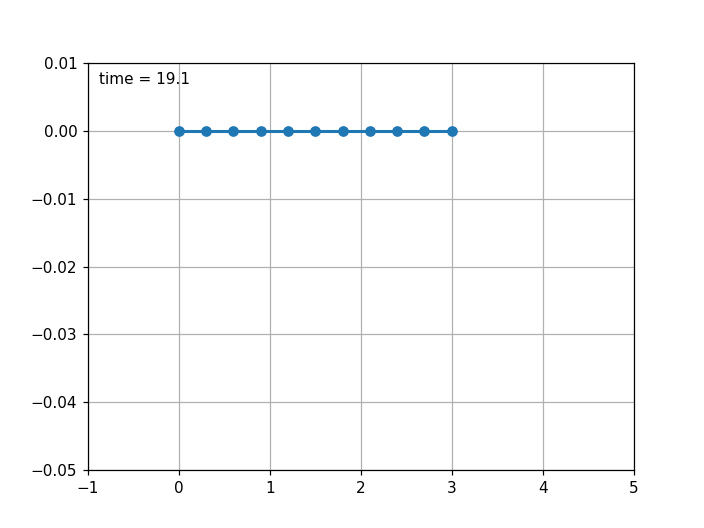

t0 = 1639611575.3959713, t1 = 1639611575.670822, frames = 300, interval = 33.058482726415


In [111]:
test = crossrod(T = T, dt = dt, total_length = L, elements = 10, density = 5E3, radius = R, total_external_force = F)

""" Animating Stuff """
fps = 30 # frames per second
graphing_dt = 1./fps # seconds per frame

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 5), ylim=(-.05, .01))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    """perform animation step"""
    global test, dt, graphing_dt

    # test.step(dt)

    for idx in np.arange(0,graphing_dt+dt,dt):
        test.step(dt)
        if idx == graphing_dt:
            print("yup")
        if idx == graphing_dt+dt:
            print("what??")

    line.set_data(test.pos[2,:],test.pos[1,:])
    time_text.set_text('time = %.001f' % test.time_elapsed)
    return line, time_text

t0 = time.time()
animate(0)
t1 = time.time()
interval = 1000 * graphing_dt - (t1 - t0)
frames = T * fps
print("t0 = {0}, t1 = {1}, frames = {2}, interval = {3}".format(t0,t1,frames,interval))

ani = animation.FuncAnimation(fig, animate, frames=frames,
                              interval=interval, blit=True, init_func=init)

plt.show()

# real_strain = (F*L)/(E*A-F)
# print(real_strain)
# print(np.average(test.final_pos))
# plt.plot(np.arange(0,T+dt,dt),test.record_mid_vel)
# plt.show()
# plt.plot(np.arange(0,T+dt,dt),test.re[0.0, 0.0, 1.0],cord_1st_pos)
# plt.show()
# plt.plot(np.arange(0,T+dt,dt),test.record_mid_pos)
# plt.show()
# plt.plot(np.arange(0,T+dt,dt),test.record_3rd_pos)
# plt.show()